Examples to demonstrate how to write an image file to a TFRecord,
and how to read a TFRecord file using TFRecordReader.

Author: Chip Huyen


Prepared for the class CS 20SI: "TensorFlow for Deep Learning Research"
cs20si.stanford.edu

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import sys
sys.path.append('..')

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# image supposed to have shape: 480 x 640 x 3 = 921600
IMAGE_PATH = 'data/'

### Protocol Buffer
feature.proto
[https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/core/example/feature.proto]

In [3]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [5]:
def get_image_binary(filename):
    """ You can read in the image using tensorflow too, but it's a drag
        since you have to create graphs. It's much easier using Pillow and NumPy
    """
    image = Image.open(filename)
    image = np.asarray(image, np.uint8)
    shape = np.array(image.shape, np.int32)
    return shape.tobytes(), image.tobytes() # convert image to raw data bytes in the array.

In [6]:
def write_to_tfrecord(label, shape, binary_image, tfrecord_file):
    """ This example is to write a sample to TFRecord file. If you want to write
    more samples, just use a loop.
    """
    writer = tf.python_io.TFRecordWriter(tfrecord_file)
    # write label, shape, and image content to the TFRecord file
    example = tf.train.Example(features=tf.train.Features(feature={
                'label': _int64_feature(label),
                'shape': _bytes_feature(shape),
                'image': _bytes_feature(binary_image)
                }))
    writer.write(example.SerializeToString())
    writer.close()

In [7]:
def write_tfrecord(label, image_file, tfrecord_file):
    shape, binary_image = get_image_binary(image_file)
    write_to_tfrecord(label, shape, binary_image, tfrecord_file)

In [8]:
def read_from_tfrecord(filenames):
    tfrecord_file_queue = tf.train.string_input_producer(filenames, name='queue')
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(tfrecord_file_queue)

    # label and image are stored as bytes but could be stored as 
    # int64 or float64 values in a serialized tf.Example protobuf.
    tfrecord_features = tf.parse_single_example(tfrecord_serialized,
                        features={
                            'label': tf.FixedLenFeature([], tf.int64),
                            'shape': tf.FixedLenFeature([], tf.string),
                            'image': tf.FixedLenFeature([], tf.string),
                        }, name='features')
    # image was saved as uint8, so we have to decode as uint8.
    image = tf.decode_raw(tfrecord_features['image'], tf.uint8)
    shape = tf.decode_raw(tfrecord_features['shape'], tf.int32)
    # the image tensor is flattened out, so we have to reconstruct the shape
    image = tf.reshape(image, shape)
    label = tfrecord_features['label']
    return label, shape, image

In [9]:
def read_tfrecord(tfrecord_file):
    label, shape, image = read_from_tfrecord([tfrecord_file])

    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        label, image, shape = sess.run([label, image, shape])
        coord.request_stop()
        coord.join(threads)
    print(label)
    print(shape)
    plt.imshow(image)
    plt.show() 

assume the image has the label Chihuahua, which corresponds to class number 1

In [10]:
label = 1 

In [11]:
image_file = IMAGE_PATH + 'friday.jpg'

In [12]:
tfrecord_file = IMAGE_PATH + 'friday.tfrecord'

In [13]:
write_tfrecord(label, image_file, tfrecord_file)

1
[322 403   3]


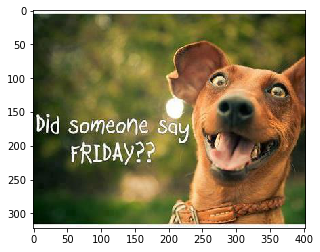

In [14]:
read_tfrecord(tfrecord_file)